In [ ]:
import cv2
import os
#from google.colab.patches import cv2_imshow
import numpy as np
import random
import torch
import torch.nn as nn
from scipy.ndimage import distance_transform_edt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data import random_split
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

False


In [ ]:
TRAINPROP = 0.8
VALPROP = 0.1
TESTPROP = 0.1
DICE_PROP = 0.8
BATCHSIZE = 16
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 15
NUM_FOLDS = 5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
folder_path = 'brain_scan/TCGA_HT_A616_19991226'

image_files = [f for f in os.listdir(folder_path) if f.endswith('mask.tif')] 
print("nombre d'images dans le dossier :", len(image_files))

sizes = []
k = 0
for file_name in image_files:
    k += 1
    file_path = os.path.join(folder_path, file_name)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    sizes.append(image.shape)

    if k == 10 :
      break

print(sizes)


nombre d'images dans le dossier : 28
[(256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256)]


brain_scan/TCGA_HT_A616_19991226\TCGA_HT_A616_19991226_15_mask.tif


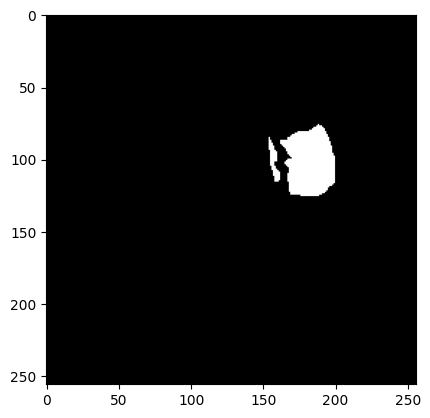

In [5]:
filename = image_files[5]
file_path = os.path.join(folder_path, filename)
image = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
print(file_path)
plt.imshow(image, cmap='gray')


In [6]:
r = np.array(image[:,:])

print(np.max(r))
print(image.shape)
print(r.shape)

255
(256, 256)
(256, 256)


In [7]:
class CustomDataset(Dataset):
  def __init__(self):
    self.name = []
    self.folder_path = 'brain_scan/'
    for f1 in os.listdir(self.folder_path):
      if not (f1 == "data.csv" or f1 == "README.md"): 
        for f2 in os.listdir(os.path.join(self.folder_path,f1)):
          if f2.endswith('mask.tif'):
            self.name.append(os.path.join(f1,f2))

  def __len__(self):
    return len(self.name)

  def __getitem__(self,idx):
    self.mask = 1/255*cv2.imread(os.path.join(self.folder_path, self.name[idx]),cv2.IMREAD_GRAYSCALE)[:,:]
    self.image = 1/255*cv2.imread(os.path.join(self.folder_path, self.name[idx].replace("_mask.tif",".tif")),cv2.IMREAD_GRAYSCALE)[:,:]

    return (torch.tensor(self.image, dtype = torch.float).unsqueeze(0), torch.tensor(self.mask, dtype = torch.float).unsqueeze(0), self.name[idx])

In [8]:
dt = CustomDataset()

In [9]:
idx_P = []
idx_N = []
for idx in range(dt.__len__()):
    mask = dt.__getitem__(idx)[1]
    r = np.array(mask[:,:])
    if np.max(r) == 0:
        idx_N.append(idx)
    else :
        idx_P.append(idx)

print(f'Proportion empty mask : {100*len(idx_N)/dt.__len__():.2f}%' )



Proportion empty mask : 63.02%


In [10]:
#Delete some of the empty mask
list_idx = random.sample(idx_N, len(idx_P)) + idx_P
#Create a subset dataset to equilibrate the dataset
equil_dt = Subset(dt, list_idx)

print(equil_dt.__len__())

1278


In [ ]:
train_ds, val_ds, test_ds = random_split(equil_dt, [TRAINPROP, VALPROP, TESTPROP])

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.contracting_block(in_channels, 32,5)
        self.enc2 = self.contracting_block(32, 64,3,2) # Use strided convolution instead of Maxpool
        self.enc3 = self.contracting_block(64, 128,3,2)
        self.enc4 = self.contracting_block(128, 256,3,2)
        self.enc5 = self.contracting_block(256, 512,3,2)

        # Decoder
        self.upconv4 = self.upconv(512, 256)
        self.dec4 = self.expanding_block(512, 256)
        self.upconv3 = self.upconv(256, 128)
        self.dec3 = self.expanding_block(256, 128)
        self.upconv2 = self.upconv(128, 64)
        self.dec2 = self.expanding_block(128, 64)
        self.upconv1 = self.upconv(64, 32)
        self.dec1 = self.expanding_block(64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1, padding='same')

        self.sigmoid = nn.Sigmoid()

        self._initialize_weights()

    def contracting_block(self, in_channels, out_channels,size,stride=1):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=size,stride=stride, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=size, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        return block

    def expanding_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        return block


    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)


    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)        

        # Decoder
        dec4 = self.upconv4(enc5)
        dec4 = self.crop_and_concat(dec4, enc4, crop=True)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = self.crop_and_concat(dec3, enc3, crop=True)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = self.crop_and_concat(dec2, enc2, crop=True)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = self.crop_and_concat(dec1, enc1, crop=True)
        dec1 = self.dec1(dec1)

        out = self.final_conv(dec1)
        out = self.sigmoid(out)

        return out

In [ ]:
unet = UNet().to(device)
print(unet)

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): 

In [ ]:
# Callbacks

class EarlyStopping:
    def __init__(self, monitor='val_loss', patience=5, restore_best_weights=True):
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_weights = None

    def __call__(self, model, current_score, current_epoch):
        if self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_weights = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model_weights:
                    model.load_state_dict(self.best_model_weights)
    
class ReduceLROnPlateau:
    def __init__(self, optimizer, monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5):
        self.optimizer = optimizer
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best_score = None
        self.counter = 0

    def __call__(self, current_score):
        if self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                for param_group in self.optimizer.param_groups:
                    new_lr = max(param_group['lr'] * self.factor, self.min_lr)
                    if param_group['lr'] > new_lr:
                        param_group['lr'] = new_lr
                        print(f"Reduced learning rate to {new_lr:.6f} \n")

class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', save_best_only=True):
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.best_score = None

    def __call__(self, model, current_score):
        if not self.save_best_only or self.best_score is None or current_score < self.best_score:
            self.best_score = current_score
            torch.save(model.state_dict(), self.filepath)
            print(f"Model saved to {self.filepath} \n")

In [ ]:
#Defining the Dice Loss
def dice_coefficient_proba(y_true, y_pred, smooth=1):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_coefficient(y_true, y_pred, smooth=1):
    y_pred = (y_pred  > 0.5).float()
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def total_loss(y_true, y_pred, smooth=1):
    loss = DICE_PROP*(1 - dice_coefficient_proba(y_true, y_pred, smooth)) + (1-DICE_PROP)*nn.BCELoss()(y_pred, y_true)
    return loss

In [15]:
criterion = total_loss

In [ ]:
#optimizer = optim.SGD(my_nn.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  0%|          | 0/64 [00:00<?, ?it/s]

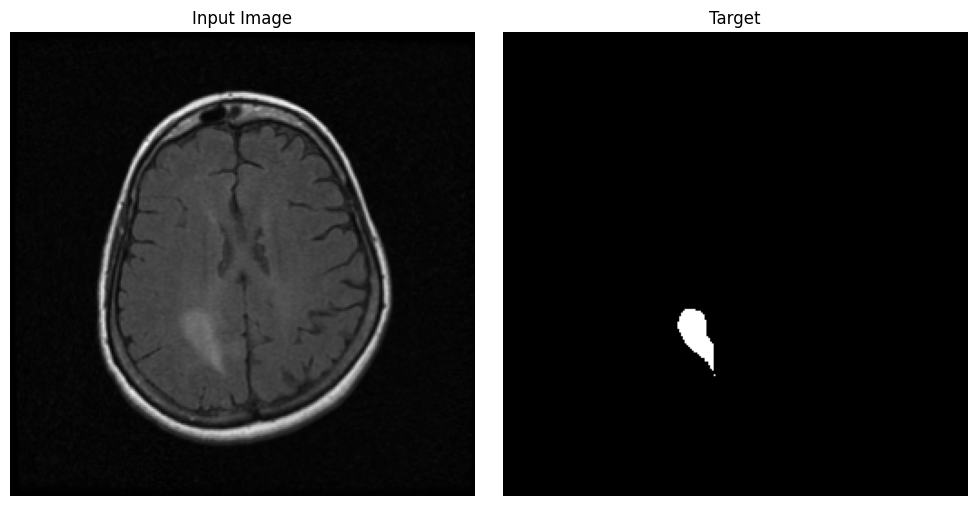

Epoch 1/15, Loss: 0.82059 - Dice Coefficient: 27.2%: 100%|██████████| 64/64 [17:34<00:00, 16.48s/it]


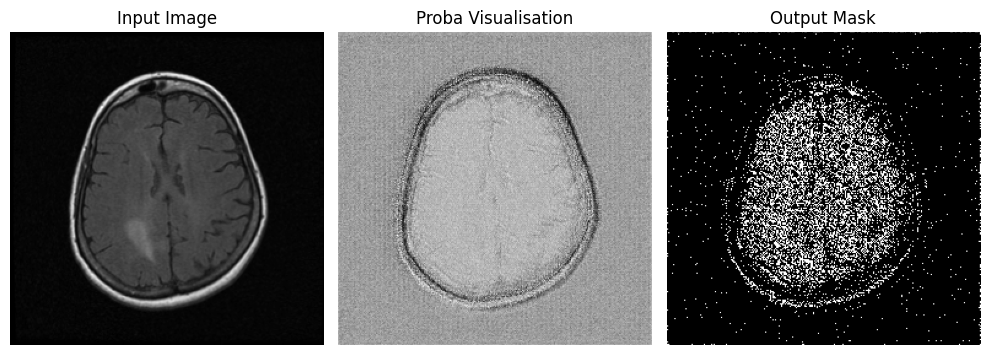

Epoch 2/15, Loss: 0.72536 - Dice Coefficient: 36.7%: 100%|██████████| 64/64 [16:57<00:00, 15.91s/it]


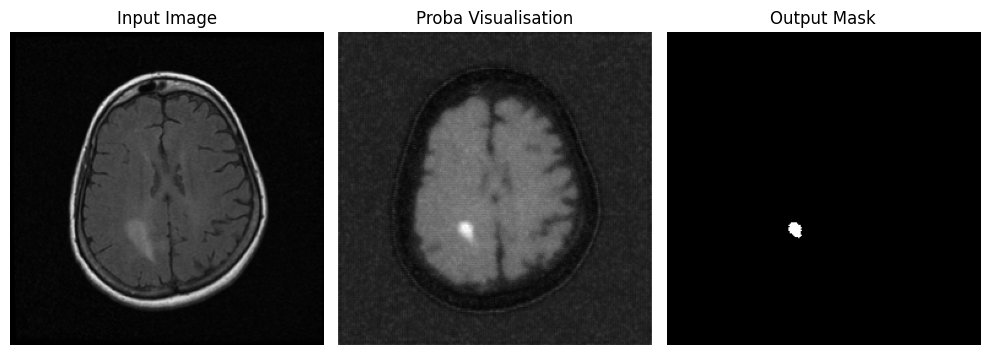

Epoch 3/15, Loss: 0.60569 - Dice Coefficient: 43.6%: 100%|██████████| 64/64 [17:11<00:00, 16.11s/it]


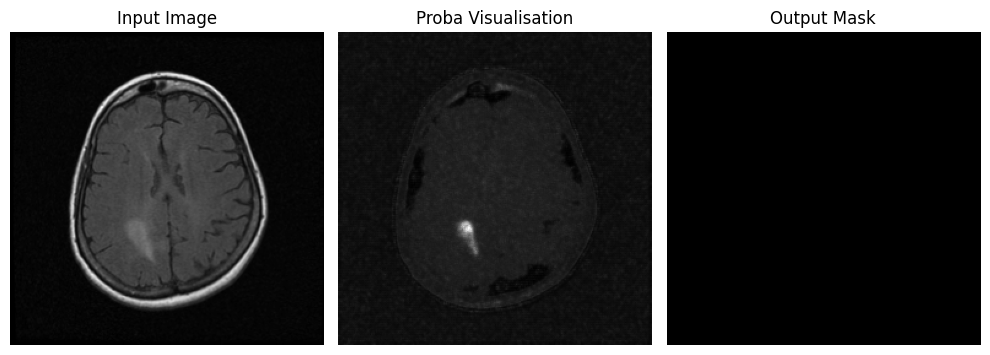

Epoch 4/15, Loss: 0.48488 - Dice Coefficient: 48.8%: 100%|██████████| 64/64 [17:21<00:00, 16.28s/it]


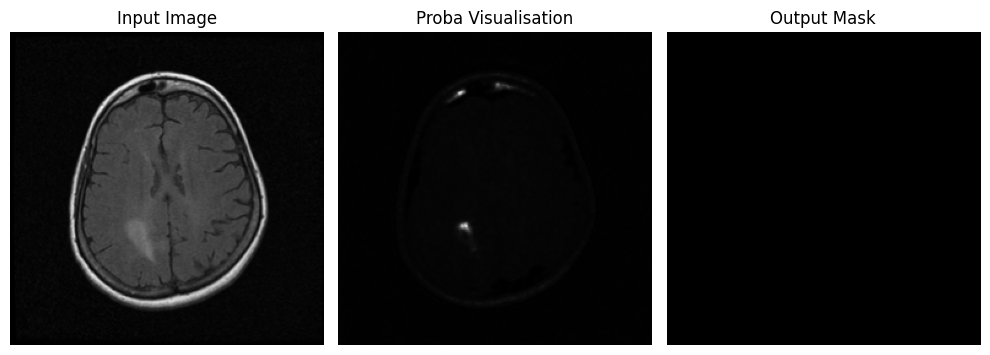

Epoch 5/15, Loss: 0.41130 - Dice Coefficient: 53.5%: 100%|██████████| 64/64 [16:53<00:00, 15.83s/it]


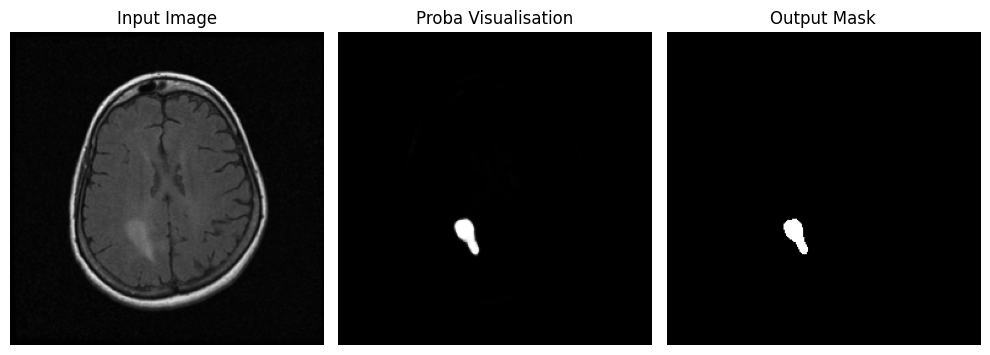

Epoch 6/15, Loss: 0.35741 - Dice Coefficient: 59.4%: 100%|██████████| 64/64 [17:08<00:00, 16.07s/it]


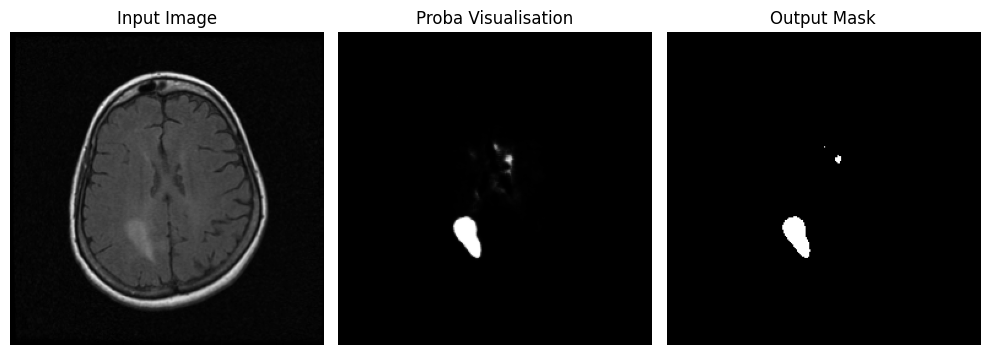

Epoch 7/15, Loss: 0.32664 - Dice Coefficient: 63.2%: 100%|██████████| 64/64 [17:09<00:00, 16.09s/it]


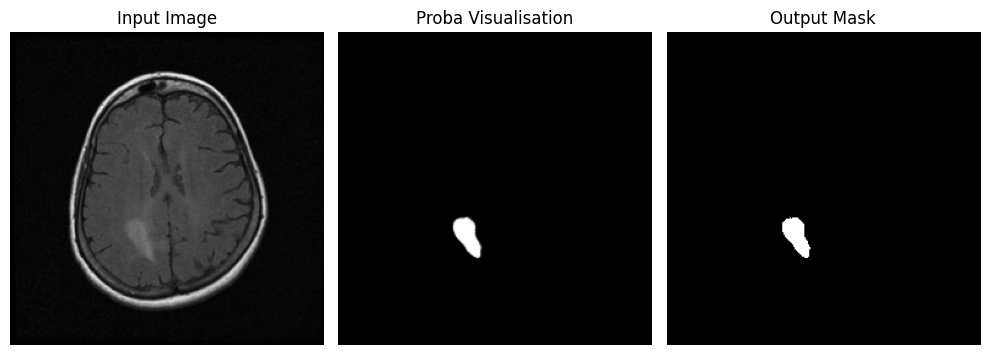

Epoch 8/15, Loss: 0.31377 - Dice Coefficient: 64.5%: 100%|██████████| 64/64 [17:08<00:00, 16.07s/it]


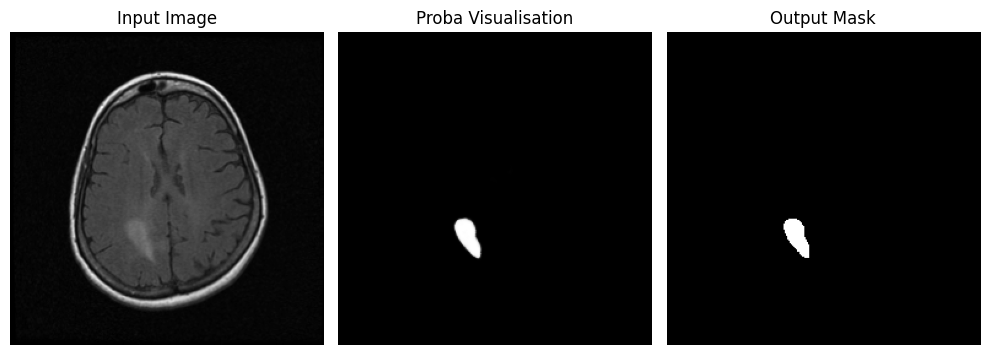

Epoch 9/15, Loss: 0.31324 - Dice Coefficient: 64.6%: 100%|██████████| 64/64 [17:04<00:00, 16.01s/it]


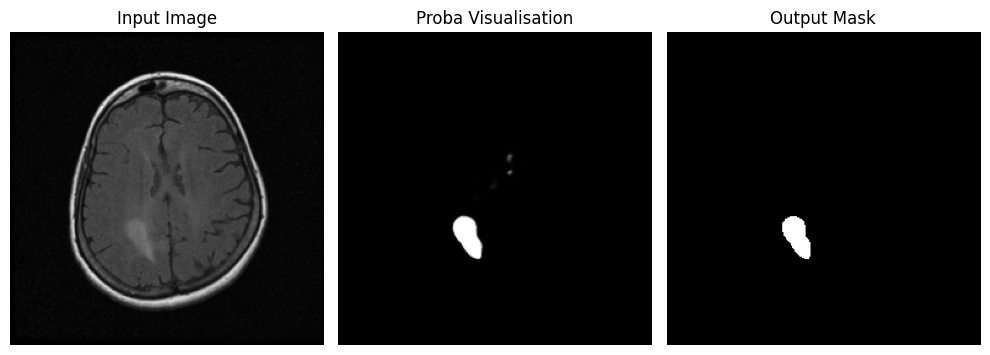

Epoch 10/15, Loss: 0.29988 - Dice Coefficient: 66.0%: 100%|██████████| 64/64 [17:15<00:00, 16.19s/it]


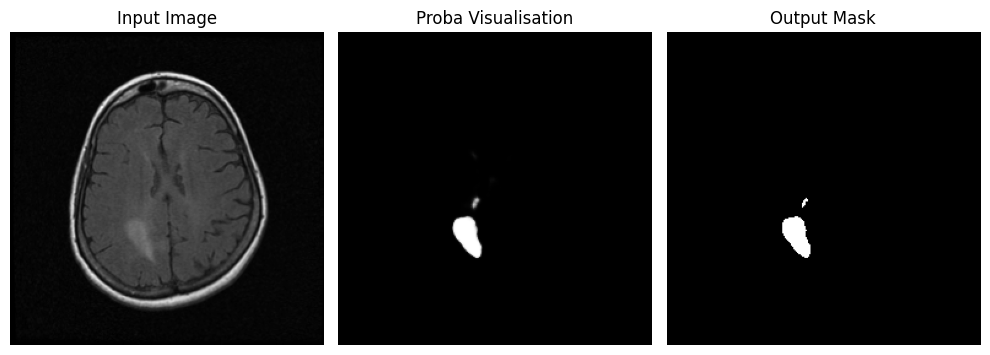

Epoch 11/15, Loss: 0.30260 - Dice Coefficient: 65.5%: 100%|██████████| 64/64 [17:11<00:00, 16.12s/it]


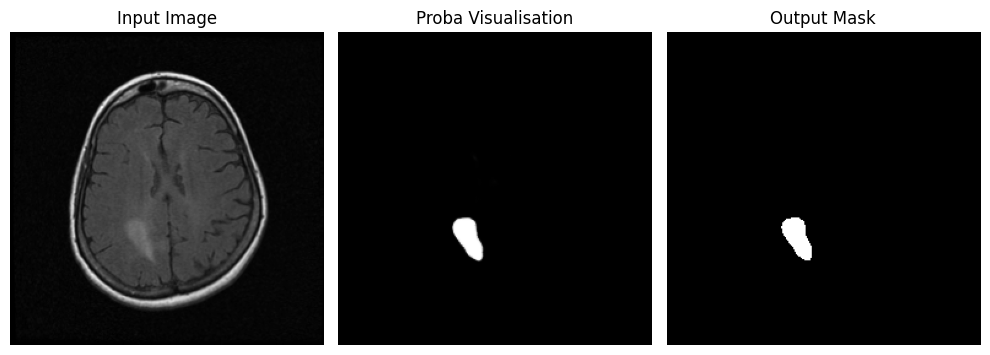

Epoch 12/15, Loss: 0.29839 - Dice Coefficient: 66.1%: 100%|██████████| 64/64 [17:09<00:00, 16.09s/it]


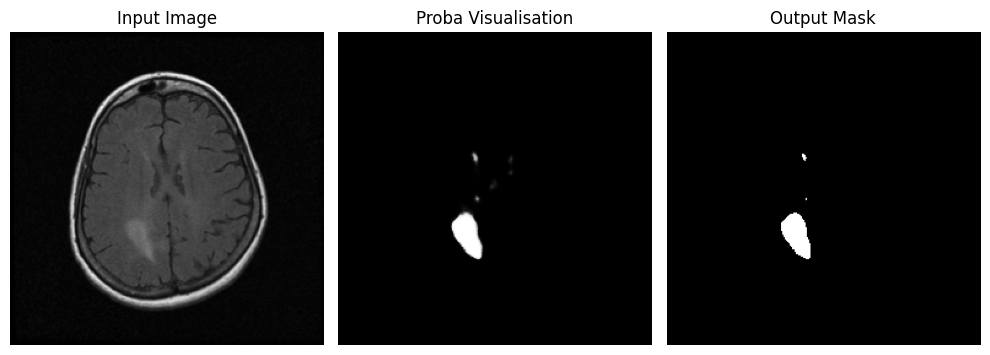

Epoch 13/15, Loss: 0.29661 - Dice Coefficient: 66.3%: 100%|██████████| 64/64 [17:19<00:00, 16.24s/it]


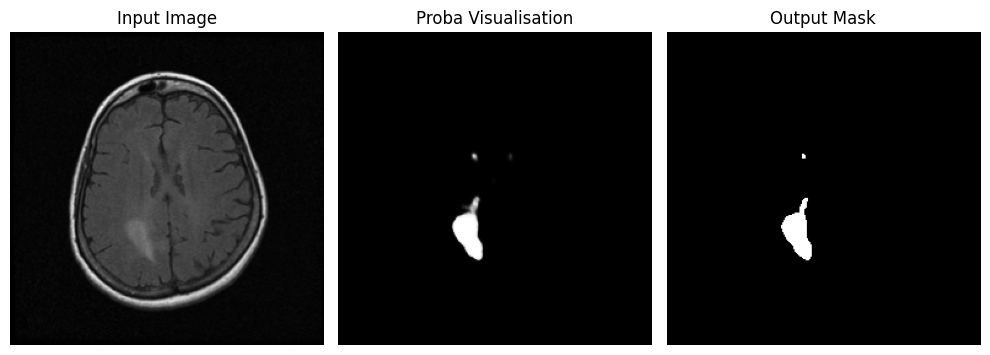

Epoch 14/15, Loss: 0.29142 - Dice Coefficient: 67.0%: 100%|██████████| 64/64 [17:12<00:00, 16.13s/it]


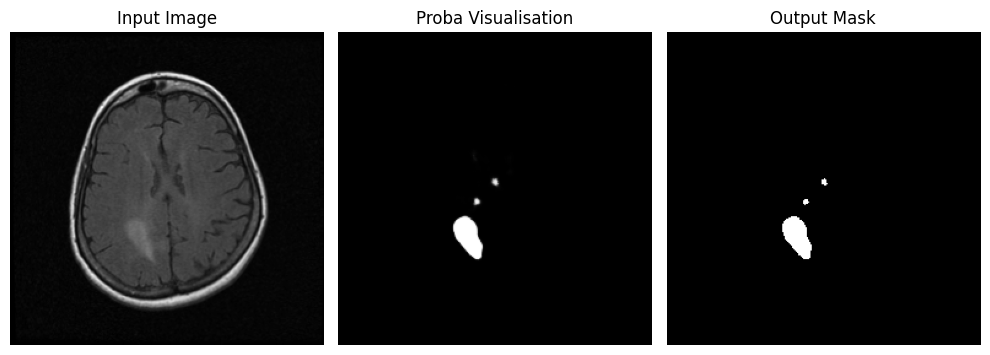

Epoch 15/15, Loss: 0.28852 - Dice Coefficient: 67.2%: 100%|██████████| 64/64 [17:14<00:00, 16.17s/it]


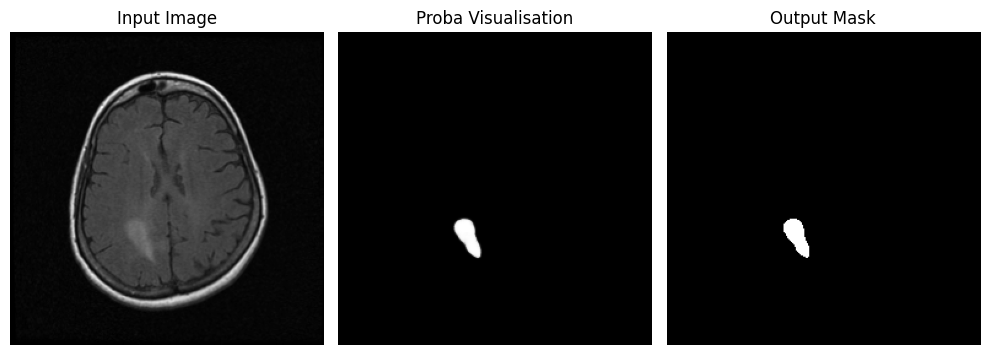

Training finished


In [ ]:
# Define data loaders for training and validation
train_dl = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCHSIZE, shuffle=True)

# Instantiate callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(optimizer, monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
checkpoint = ModelCheckpoint('unet_model.pth', monitor='val_loss', save_best_only=True)

# Visualization list and flag for saving the label
ref_name = ''
name_saved = False

for epoch in range(EPOCHS):
    training_loss = 0.0
    training_dice_coeff = []
    dataloader = tqdm(train_dl, position=0, leave=True)

    # Training Phase
    unet.train()
    for inputs, labels, name in dataloader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = unet(inputs)
        
        loss = criterion(labels, outputs)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        training_dice_coeff.append(dice_coefficient(labels, outputs).item())

        dataloader.set_description(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {training_loss / len(train_dl):.5f} - Mean Training Dice Coefficient: {100 * sum(training_dice_coeff) / len(training_dice_coeff):.1f}%')
        dataloader.refresh()
    
    scheduler.step()
    dataloader.close()

    # Validation Phase
    unet.eval()
    val_loss = 0.0
    val_dice_coeff = []
    with torch.no_grad():
        for inputs, labels, name in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = unet(inputs)
            loss = criterion(labels, outputs)

            val_loss += loss.item()
            val_dice_coeff.append(dice_coefficient(labels, outputs).item())
        
        print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {val_loss / len(val_dl):.5f} - Mean Validation Dice Coefficient: {100 * sum(val_dice_coeff) / len(val_dice_coeff):.1f}% \n')

    dataloader.close()

    # Callbacks
    early_stopping(unet, val_loss, epoch)
    reduce_lr(val_loss)
    checkpoint(unet, val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print('Training finished')


In [20]:
test_dl = DataLoader(test_ds, batch_size=BATCHSIZE, shuffle=True)

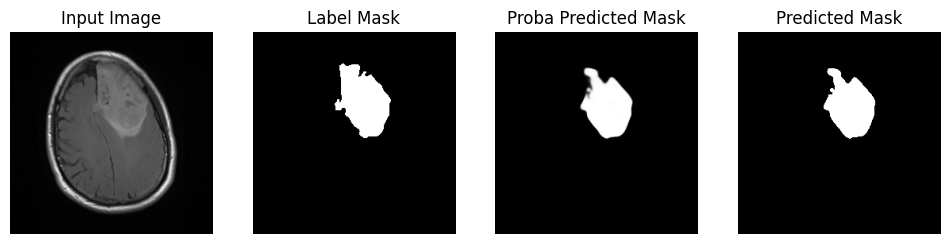

0.7368465065956116
Mean Dice Coefficient: 66.9%


In [ ]:
unet.eval()
val_dice_coeff = []
example_showed = False
k = 0
for inputs, labels , name in test_dl:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = unet(inputs)
    val_dice_coeff.append(dice_coefficient(labels, outputs).item())
    


    if not example_showed and np.max(labels[0, 0, :, :].cpu().numpy()) == 1:
        input_image = inputs[0, 0, :, :].cpu().numpy()
        label_mask = labels[0, 0, :, :].cpu().numpy()
        predicted_mask_proba = outputs[0, 0, :, :].float().detach().cpu().numpy()
        predicted_mask = (outputs[0, 0, :, :]> 0.5).float().detach().cpu().numpy()

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 4, 1)
        plt.imshow(input_image, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(label_mask, cmap='gray')
        plt.title('Label Mask')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask_proba, cmap='gray')
        plt.title('Proba Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

        print(dice_coefficient(outputs, labels).item())

        example_showed = True



dataloader.close()
print(f'Mean Dice Coefficient: {100 * sum(val_dice_coeff) / len(val_dice_coeff):.1f}%')